<a href="https://colab.research.google.com/github/smjune/ipynb/blob/main/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Math and data preprocessing libraries
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For deep learning
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [10]:
train_df = pd.read_csv('train_data.csv', parse_dates=['date'])
test_df = pd.read_csv('test_data.csv', parse_dates=['date'])
df = pd.concat([train_df, test_df]).set_index('date', drop=True)

print(df.head())

             meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666667
2013-01-02   7.400000  92.000000    2.980000   1017.800000
2013-01-03   7.166667  87.000000    4.633333   1018.666667
2013-01-04   8.666667  71.333333    1.233333   1017.166667
2013-01-05   6.000000  86.833333    3.700000   1016.500000


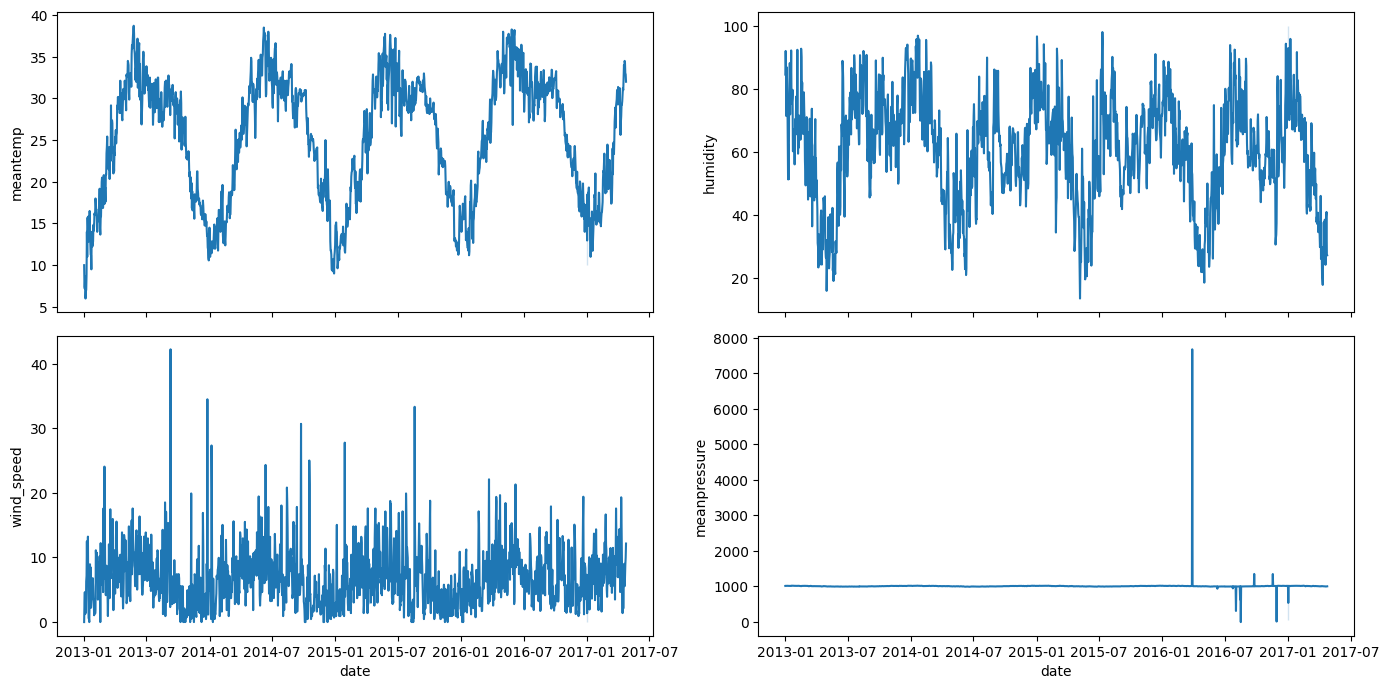

In [11]:
ncols = 2
nrows = math.ceil(df.shape[1] / ncols)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
  sns.lineplot(data=df.iloc[:, i], ax=ax)
fig.tight_layout()
plt.show()

In [12]:
train_ratio = 0.8
train_len = math.ceil(len(df) * train_ratio)
train_data = df[:train_len][['meantemp']]
test_data = df[train_len:][['meantemp']]

print(train_data.shape)  # (1261, 1)
print(test_data.shape)  # (315, 1)

(1261, 1)
(315, 1)


In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data.values)
test_scaled = scaler.transform(test_data.values)

for v in train_data.values[:5, 0]:
  print(f'{v:6.3f}', end=' ')  # 10.000  7.400  7.167  8.667  6.000
print()

for v in train_scaled[:5, 0]:
  print(f'{v:6.3f}', end=' ')  #  0.122  0.043  0.036  0.082  0.000

10.000  7.400  7.167  8.667  6.000 
 0.122  0.043  0.036  0.082  0.000 

In [14]:
sequence_length = 50  # Number of time steps to look back

def convert_data_into_tensors(data_seq):
  features, labels = [], []
  for i in range(len(data_seq) - sequence_length):
      features.append(data_seq[i:i + sequence_length])
      labels.append(data_seq[i + sequence_length, 0])
  features, labels = np.array(features), np.array(labels)

  features = torch.tensor(features, dtype=torch.float32)
  labels = torch.tensor(labels, dtype=torch.float32)
  return features, labels

X_train, y_train = convert_data_into_tensors(train_scaled)
X_test, y_test = convert_data_into_tensors(test_scaled)

print(X_train.shape)  # torch.Size([1211, 50, 1])
print(y_train.shape)  # torch.Size([1211])
print(X_test.shape)   # torch.Size([265, 50, 1])
print(y_test.shape)   # torch.Size([265])

torch.Size([1211, 50, 1])
torch.Size([1211])
torch.Size([265, 50, 1])
torch.Size([265])


In [17]:
batch_size = 32

def to_loader(x, y, batch_size, shuffle):
  dataset = torch.utils.data.TensorDataset(x, y)
  return torch.utils.data.DataLoader(dataset, batch_size, shuffle)

train_loader = to_loader(X_train, y_train, batch_size, shuffle=True)
test_loader = to_loader(X_test, y_test, batch_size, shuffle=False)

In [18]:
input_size = X_train.shape[-1]
num_layers = 2
hidden_size = 64

class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.lstm(x)
    return self.linear(out)

model = LSTMModel(input_size, hidden_size, num_layers).to(device)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)

# LSTMModel(
#   (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
#   (linear): Linear(in_features=64, out_features=1, bias=True)
# )

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [19]:
num_epochs = 10
train_hist = []
test_hist = []

for epoch in range(num_epochs):
  total_loss = 0.0
  total_test_loss = 0.0

  model.train()
  for batch_x, batch_y in train_loader:
    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
    pred = model(batch_x)[:, -1, 0]
    loss = loss_fn(pred, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  train_hist.append(avg_loss)

  model.eval()
  with torch.no_grad():
    for test_x, test_y in test_loader:
      test_x, test_y = test_x.to(device), test_y.to(device)
      test_pred = model(test_x)[:, -1, 0]
      test_loss = loss_fn(test_pred, test_y)

      total_test_loss += test_loss.item()

  avg_test_loss = total_test_loss / len(test_loader)
  test_hist.append(avg_test_loss)

  print(f'Epoch {epoch + 1:2d}/{num_epochs} - Training Loss: {avg_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Epoch  1/10 - Training Loss: 0.1314, Test Loss: 0.0334
# Epoch  2/10 - Training Loss: 0.0262, Test Loss: 0.0119
# Epoch  3/10 - Training Loss: 0.0088, Test Loss: 0.0065
# Epoch  4/10 - Training Loss: 0.0070, Test Loss: 0.0056
# Epoch  5/10 - Training Loss: 0.0059, Test Loss: 0.0052
# Epoch  6/10 - Training Loss: 0.0054, Test Loss: 0.0052
# Epoch  7/10 - Training Loss: 0.0051, Test Loss: 0.0050
# Epoch  8/10 - Training Loss: 0.0048, Test Loss: 0.0045
# Epoch  9/10 - Training Loss: 0.0047, Test Loss: 0.0047
# Epoch 10/10 - Training Loss: 0.0047, Test Loss: 0.0043

Epoch  1/10 - Training Loss: 0.0993, Test Loss: 0.0327
Epoch  2/10 - Training Loss: 0.0210, Test Loss: 0.0069
Epoch  3/10 - Training Loss: 0.0076, Test Loss: 0.0060
Epoch  4/10 - Training Loss: 0.0061, Test Loss: 0.0054
Epoch  5/10 - Training Loss: 0.0056, Test Loss: 0.0048
Epoch  6/10 - Training Loss: 0.0053, Test Loss: 0.0054
Epoch  7/10 - Training Loss: 0.0052, Test Loss: 0.0045
Epoch  8/10 - Training Loss: 0.0051, Test Loss: 0.0051
Epoch  9/10 - Training Loss: 0.0050, Test Loss: 0.0047
Epoch 10/10 - Training Loss: 0.0047, Test Loss: 0.0046


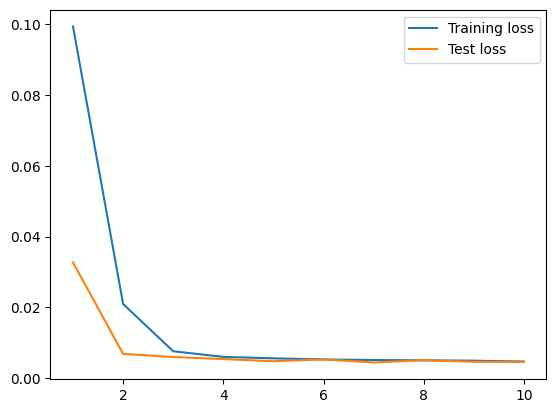

In [20]:
x = np.linspace(1, num_epochs, num_epochs)
plt.plot(x, train_hist, scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

In [21]:
num_forecast_steps = 30
input_data = X_test[-2 * num_forecast_steps:-num_forecast_steps].cpu().numpy()

forecasted_values = []
with torch.no_grad():
  for i in range(2 * num_forecast_steps):
    input_tensor = torch.as_tensor(input_data).view(1, -1, 1).to(device)
    predicted = model(input_tensor)[0, -1, 0].item()

    forecasted_values.append(predicted)
    input_data = np.roll(input_data, shift=-1)

    if i < num_forecast_steps:
      input_data[-1] = y_test[-num_forecast_steps + i]
    else:
      input_data[-1] = predicted

df_out = df.copy()
last_date = df_out.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=num_forecast_steps)
combined_dates = df_out.index.append(future_dates)

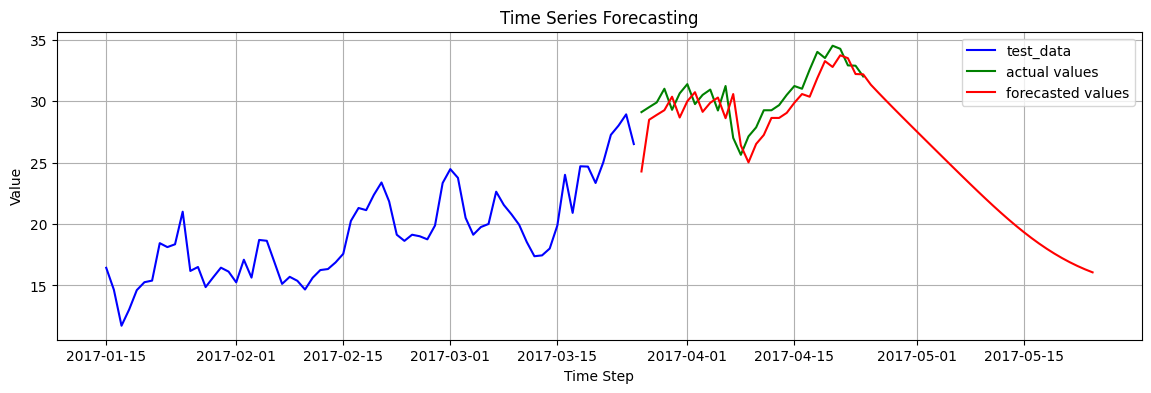

In [22]:
plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(test_data.index[-100:-30], test_data[-100:-30], label = "test_data", color = "b")
plt.plot(test_data.index[-30:], test_data.iloc[-30:], label='actual values', color='green')

forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten()
plt.plot(combined_dates[-60:], forecasted_cases, label='forecasted values', color='red')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)